# **Physics-based loss and machine learing approach in application to fluids flow modelling: 2D flow domains**

The program recieves an image of the flow domain and the flow rate value, then calculate velocity distribution. The main idea is power loss minimization. The main unknown function is the stream function $\psi = \psi(x_1, x_2)$ that determines the velocity field $\textbf{V} = [[v_1, v_2]]$, where $v_1 = \frac{\partial \psi}{\partial x_2}$, $v_2 = - \frac{\partial \psi}{\partial x_1}$.



# Initialization
## Import libraries

In [1]:
# Pytorch modules
import torch
from torch import nn
from torch import autograd


# Plotting
from matplotlib import pyplot as plt
from matplotlib import transforms
import numpy as np

# Python functions
from collections import namedtuple
from itertools import product
from collections import OrderedDict
#from scipy import integrate

# Status bar
from tqdm.notebook import tqdm
from datetime import datetime
import time

# Work with files and images
import json
from pathlib import Path
import os, fnmatch
import re
from PIL import Image

#Log
# import neptune.new as neptune
# from neptune.new.types import File

import time

## Neptune project

In [2]:
# run = neptune.init(
#     project="avkornaev/PhysicsBasedDL",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRjMGY4Ny1hYTI1LTQxZmEtYjRmZC02YzNkYWZjYzNiNjIifQ==",
# )  # your credentials

## Path

In [3]:
 path =  Path('./')
 imgPath = path/'ToyDataset'
 imgList = fnmatch.filter(os.listdir(imgPath), '*.png') #imgPath.ls()
 imgList

['Nailfold_capillary.png',
 'Parallel plates 1x16.png',
 'Parallel plates 1x4.png',
 'Parallel plates with notch.png',
 'Parallel plates.png']

## Download and preprocess image of the flow domain

## Constants

In [4]:
#Training
SIZE = 256 # image size (128, 256, 512)
EPOCHS = 10000
NoOfFeatures = 32 #32
WORK_DIR = './'
#SCALE_FACTOR = 1 # muliplier for the loss function
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "FCN"
EARLY_STOP_PATIENCE = 1000
DECAY = 0
MSE = torch.nn.L1Loss()

parameters = {'image_size':SIZE,
             'Epochs':EPOCHS,
             'Model':MODEL_NAME,
             'No_of_features':NoOfFeatures}

HYPS = []

hyps = {"learning_rate": [1e-3],
        "scheduler": ["None"],
        "scheduler_factor": [0.1],
        "scheduler_patience": [200],
        "hidden_layers": [10],
        "hidden_neurons": [32], 
        "Early_stop_patience": [EARLY_STOP_PATIENCE],
        "Decay": [DECAY],  # L2 norm
        "optimizer": ['Adam']}
    
for i in product(*[hyps[j] for j in hyps]):
    HYPS.append({a:b for a, b in zip(hyps, i)})
#"scheduler": ["None", "step", "cycle"]
#"use_bn": [True, False]

#Visualization
sp = int(SIZE/2)#slice position
vps = 10 #vector plot step 
FIGSIZE = 5 # figure size
#S2 = int(SIZE*0.4)
#S3 = SIZE - S2
UP_COLOR  =  torch.tensor((0, 255, 0)) # upper wall color is green 
LOW_COLOR =  torch.tensor((0, 0, 255)) # upper wall color is blue
#CENTER_COLOR = torch.tensor((1, 1, 1)) # flow domain

## Log parameters

In [5]:
# run["config/parameters"] = parameters
# run["config/hyperparameters"] = hyps

## Geometry of the flow domain, fluid properties and boundary conditions
The fluid is Newtonian.
The domain of size *'L x L'*  with flow channel is represented as an image of size *'SIZE x SIZE'*. $S_1$ is the upper wall with the green label [0 255 0]. $S_2$ and $S_4$ are outlet and inlet surfaces, respectivelly. $S_3$ is the lower wall with the blue label [0 0 255]. No-slip condition is applied on the walls. The flow rate is given and equal to $Q$.

In [6]:
#Image number from the imgList
imgNo = 0

#read proporion from the title
regex = re.compile(r'\d+')
proportion = regex.findall(imgList[imgNo])

# L x L flow domain
L = 0.012#0.0024#
h = L/4 # h is thickness of the gap between 2 parallel plates when 'Parallel plates.png' is under study

# Normalized coordinates, finite diferences, limits and elementary surface area
X1N = torch.linspace(0, 1, SIZE)
X2N = torch.linspace(0, 1, SIZE)

X1N_V, X2N_V = torch.meshgrid([X1N, X2N], indexing='ij')

DX1N = X1N[1] - X1N[0]
DX2N = X2N[1] - X2N[0]
LIM1 = [0, L]
LIM2 = [0, L]
ds = DX1N * DX2N * LIM1[1] * LIM2[1] # elementary surface area

# Flow rate through the inlet (outlet) boundary, m^3/s
Q = 5E-4#0.0000005#

# Koefficient of dynamic viscosity (viscosity), Pa*s
# Herschel-Bulkley model mu = q0 + q1*Eta^(z-1)
Q0 = 1e-3
Q1 = 0
Z = 1

MU = 1e-3 # 2.65e-3 
# Density, kg/m**3
RHO = 1000

#Mass force
Fm = [-1.18E-5/(h*L), 0]

## Additional functions

Numerical derivative

In [7]:
def num_diff_1(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
    # x1 derivative:
    df_dx1[:, 1:n2-1] = (f[:, 2:] - f[:, :-2]) / (2 * dx1)
    df_dx1[:, 0] = (-f[:, 2] + 4 * f[:,1] - 3 * f[:,0]) / (2 * dx1)
    df_dx1[:, n2-1] = (3 * f[:,n2-1] - 4 * f[:,n2-2] + f[:,n2-3]) / (2 * dx1)
    # x2 derivative:
    df_dx2[1:n1-1, :] = (f[2:, :] - f[:-2,:]) / (2 * dx2)
    df_dx2[0, :] = (- f[2,:] + 4 * f[1,:] - 3 * f[0, :]) / (2 * dx2)
    df_dx2[n1-1, :] = (3 * f[n1 - 1, :] - 4 * f[n1 - 2, :] + f[n1 - 3, :]) / (2 * dx2)

    return df_dx1, df_dx2

In [8]:
def num_diff(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
    # x1 derivative:
    df_dx1[:, 1:n2-1] = (-3*f[:, 0:n2-2] +4*f[:, 1:n2-1] - f[:, 2:n2]) / (2 * dx1)
    df_dx1[:, 0] = (3 * f[:,n2-1] - 4 * f[:,n2-2] + f[:,n2-3]) / (2*dx1)
    df_dx1[:, n2-1] = (3 * f[:,n2-2] - 4 * f[:,n2-3] + f[:,n2-4]) / (2*dx1)
    # x2 derivative:
    df_dx2[0:n1-2, :] = (-3*f[0:n1-2,:] +4*f[1:n1-1,:] - f[2:n1,:]) / (2 * dx2)
    df_dx2[n1-1, :] = (3 * f[n1-1,:] - 4 * f[n1-2,:] + f[n1-3,:]) / (2 * dx2)
    df_dx2[n1-2, :] = (3 * f[n1-2,:] - 4 * f[n1-3,:] + f[n1-4,:]) / (2 * dx2)

    return df_dx1, df_dx2

In [9]:
def num_diff_5_points(f, dx1, dx2):
    '''Numerical partial derivatives of a function of two variables f = f(x1, x2):
    i - index along x1
    j - index along x2
    for the internal points - central differences e.q. df_dx = (f_{i+1}-f_{i-1})/(2*dx)
    for the boundaries - left or right finite differences e.q. df_dx = (f_{i+1}-f_{i})/dx or df_dx = (f_{i}-f_{i-1})/dx
    '''
    n1, n2 = f.shape
    df_dx1 = 0
    df_dx2 = 0
    df_dx1, df_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    d2f_dx1, d2f_dx2 = torch.zeros(n1, n2), torch.zeros(n1, n2)
    if torch.cuda.is_available():
        df_dx1 = df_dx1.to('cuda')
        df_dx2 = df_dx2.to('cuda')
        d2f_dx1 = df_dx1.to('cuda')
        d2f_dx2 = df_dx2.to('cuda')
    
      # 1st order x1 derivative:
    df_dx1[:, 2:n2-2] = (-f[:, 4:] + 8 * f[:, 3:n2-1] - 8 * f[:, 1:n2-3] + f[:, :n2-4]) / (12 * dx1)
    df_dx1[:, 0] = (-3 * f[:,4] + 16 * f[:, 3] - 36 * f[:, 2] + 48 * f[:, 1] - 25 * f[:,0]) / (12*dx1)
    df_dx1[:, 1] = (f[:,4] - 6 * f[:, 3] + 18 * f[:, 2] - 10 * f[:, 1] - 3 * f[:,0]) / (12*dx1)
    df_dx1[:, n2-2] = (3 * f[:, n2-1] + 10 * f[:, n2-2] - 18 * f[:, n2-3] + 6 * f[:, n2-4] - f[:,n2-5]) / (12*dx1)
    df_dx1[:, n2-1] = (25 * f[:, n2-1] - 48 * f[:, n2-2] + 36 * f[:, n2-3] - 16 * f[:, n2-4] + 3 * f[:,n2-5]) / (12*dx1)
      
      # 1st order x2 derivative:
    df_dx2[2:n1-2, :] = (-f[4:, :] + 8 * f[3:n1-1, :] - 8 * f[1:n1-3, :] + f[:n1-4, :]) / (12 * dx2)
    df_dx2[0, :] = (-3 * f[4, :] + 16 * f[3, :] - 36 * f[2, :] + 48 * f[1, :] - 25 * f[0, :]) / (12 * dx2)
    df_dx2[1, :] = (f[4, :] - 6 * f[3, :] + 18 * f[2, :] - 10 * f[1, :] - 3 * f[0, :]) / (12 * dx2)
    df_dx2[n1-2, :] = (3 * f[n1-1, :] + 10 * f[n1-2, :] - 18 * f[n1-3, :] + 6 * f[n1-4, :] - f[n1-5, :]) / (12 * dx2)
    df_dx2[n1-1, :] = (25 * f[n1-1, :] - 48 * f[n1-2, :] + 36 * f[n1-3, :] - 16 * f[n1-4, :] + 3*f[n1-5, :]) / (12 * dx2)

#     # 2nd order x1 derivative:
#     d2f_dx1[:, 2:n2-2] = (-f[:, 4:] + 16 * f[:, 3:n2-1] - 30 *f[:, 2:n2-2] + 16* f[:, 1:n2-3] - f[:, :n2-4]) / (12 * dx1**2)
#     d2f_dx1[:, 0] = (11 * f[:,4] - 56 * f[:, 3] + 114 * f[:, 2] - 104 * f[:, 1] + 35 * f[:,0]) / (12*dx1**2)
#     d2f_dx1[:, 1] = (-f[:,4] + 4 * f[:, 3] + 6 * f[:, 2] - 20 * f[:, 1] + 11 * f[:,0]) / (12*dx1**2)
#     d2f_dx1[:, n2-2] = (11 * f[:, n2-1] - 20 * f[:, n2-2] + 6 * f[:, n2-3] + 4 * f[:, n2-4] - f[:,n2-5]) / (12*dx1**2)
#     d2f_dx1[:, n2-1] = (35 * f[:, n2-1] - 104 * f[:, n2-2] + 114 * f[:, n2-3] - 56 * f[:, n2-4] + 11 * f[:,n2-5]) / (12*dx1**2)

#     # 2nd order x2 derivative:
#     d2f_dx2[2:n1-2, :] = (-f[4:, :] + 16 * f[3:n1-1, :] - 30 *f[2:n1-2, :] + 16* f[1:n1-3, :] - f[:n1-4, :]) / (12 * dx2**2)
#     d2f_dx2[0, :] = (11 * f[4, :] - 56 * f[3, :] + 114 * f[2, :] - 104 * f[1, :] + 35 * f[0, :]) / (12*dx2**2)
#     d2f_dx2[1, :] = (-f[4, :] + 4 * f[3, :] + 6 * f[2, :] - 20 * f[1, :] + 11 * f[0, :]) / (12*dx2**2)
#     d2f_dx2[n1-2, :] = (11 * f[n1-1, :] - 20 * f[n1-2, :] + 6 * f[n1-3, :] + 4 * f[n1-4, :] - f[n1-5, :]) / (12*dx2**2)
#     d2f_dx2[n1-1, :] = (35 * f[n1-1, :] - 104 * f[n1-2, :] + 114 * f[n1-3, :] - 56 * f[n1-4, :] + 11 * f[n1-5, :]) / (12*dx2**2)

    return df_dx1, df_dx2


def diff_auto(f, x1, x2):
    df_dx1 = autograd.grad(f.sum(), x1, create_graph=True)[0]
    df_dx2 = autograd.grad(f.sum(), x2, create_graph=True)[0]
    return df_dx1, df_dx2

Check numerical differentiations

In [10]:
xx = torch.linspace(0, 1, 100)
xx, yy = torch.meshgrid(xx, xx)

dxx = xx[1][0]-xx[0][0]
zz = xx**3 + yy**3

diffzz = 3*xx**2 + 3*yy**2
diff1, diff2 = num_diff_5_points(zz, dxx, dxx) 
diffzz_= diff1 + diff2

intzz1 = torch.trapz(diffzz)*dxx
intzz2 = torch.trapz(intzz1)*dxx

intzz1_ = torch.trapz(diffzz_)*dxx
intzz2_ = torch.trapz(intzz1_)*dxx

print(f'exact solution {intzz2}, approximate solution {intzz2_}')

C:\Users\IMS\anaconda3\envs\Pytorch\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


exact solution 2.0001022815704346, approximate solution 2.0001018047332764


Numerical integrals: single and double can be implemented by torch.trapezoid function https://pytorch.org/docs/stable/generated/torch.trapezoid.html#torch.trapezoid

Visualization

In [11]:
def vector_plot(arg, vec, FIGSIZE, vptitle='vector_plot',step=10):
    gradmag = np.sqrt(vec[0]**2+vec[1]**2)
    plt.pcolor(arg[0], arg[1], gradmag, cmap='rainbow')
    plt.colorbar()
    plt.quiver(arg[0][::step,::step], arg[1][::step,::step], vec[0][::step,::step], vec[1][::step,::step])
    plt.title(vptitle)
 

Color filter

In [12]:
# def colorFilter(img, color):
#     white = (255,255,255,255)
#     black = (0,0,0,255)
#     width,heigth = img.size
#     for i in range(width):
#         for j in range(heigth):
#             if img.getpixel((i,j)) == color:
#                 img.putpixel((i,j),black)
#         else:
#             #print(img.getpixel((i,j)))
#             img.putpixel((i,j),white)
#     return img

# def inverseColorFilter(img, color):
#     white = (255,255,255,255)
#     black = (0,0,0,255)
#     width,heigth = img.size
#     for i in range(width):
#         for j in range(heigth):
#             if img.getpixel((i,j)) == color:
#                 img.putpixel((i,j),white)
#         else:
#             #print(img.getpixel((i,j)))
#             img.putpixel((i,j),black)
#     return img

## Major functions

Distributions: the velocity components [[$v_1$, $v_2$]], the strain rate tensor components [[$\xi_{ij}$]], $\xi_{ij}=\xi_{ji}$ . And the shear rate intensity Η. 

In [13]:
def velocityDistr(psi,dx1n,dx2n,lim1,lim2):
    '''Velocity distribution [[v1, v2]] in the flow domain
    '''
    n = psi.shape
    v1 = 0
    v2 = 0
    dpsidx1 = 0
    dpsidx2 = 0
    dpsidx1, dpsidx2 = diff_auto(psi, dx1n, dx2n)
    v2 = - dpsidx2 / lim2[1]
    v1 = dpsidx1 / lim1[1]
    
    return v1,v2

In [14]:
def TksiDistr(v1,v2,dx1n,dx2n,lim1,lim2):
    '''Strain rate tensor Txi and the shear rate intensity Eta squared
    '''    
    n = v1.shape
    xi11 = 0
    xi12 = 0
    xi22 = 0
    dv1dx1 = 0
    dv1dx2 =0
    dv2dx1 = 0
    dv2dx2 = 0
  
    dv1dx1, dv1dx2 = diff_auto(v1, dx1n, dx2n)
    dv2dx1, dv2dx2 = diff_auto(v2, dx1n, dx2n)
  
    xi11 = dv1dx1 / lim1[1]
    xi12 = 0.5 * (dv1dx2 / lim2[1] + dv2dx1 / lim1[1])
    xi22 = dv2dx2 / lim2[1]
    EtaEta = (2 * (xi11 * xi11 + 2* xi12 * xi12 + xi22 * xi22))
  
    return xi11, xi12, xi22, EtaEta

## Callbacks

In [15]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

## Training function

In [16]:
def train(model, inp, optimizer,
          criterion, epochs, print_every, callbacks, lr_scheduler):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        inp (Tensor): Inpu image.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    train_print = ''
    state_text_last = ''
    bar = tqdm(range(epochs), desc="Epoch", postfix=train_print)
    for e in range(epochs):        
        model.train()

        running_loss = 0

        stop = False
        
        steps = 0
        
        optimizer.zero_grad()
        
        x1 = X1N_V.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        x2 = X2N_V.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
        
        x = torch.cat((x1, x2), axis=1)
#         x = torch.cat((x1, x2, psi0_masked.reshape(-1, 1).to(DEVICE)), axis=1)

        
#         x = (Q * x1 * x2) / 2
#         x = x.reshape(1, 1 ,SIZE, SIZE) * flowDomainMask.to(DEVICE) + (lowerWallMask.to(DEVICE)*Q)
        
        out = model.forward(x)
            
        loss = criterion(out, x1, x2)
#         run["training/batch/loss_training"].log(loss)

        loss.backward()
                
        optimizer.step(lambda: loss)
            
        with torch.no_grad():
            running_loss = loss.item()
        
        if (e + 1) % print_every == 0:
            print(f'epoch {e+1}/{epochs}, loss = {running_loss}')
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            model.train()
            
        
        history['Train loss'].append(running_loss)
        
        if lr_scheduler:
            if "OneCycleLR" in str(lr_scheduler):
                lr_scheduler.step()
            else:
                lr_scheduler.step(running_loss)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    state_text_last = state_text
                if state:
                    stop = True
        if stop:
            train_print = "Train loss: {:.4f}".format(running_loss) + ', ' + state_text_last
            bar.postfix = train_print
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            targets = None
            outputs = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
            
        if e + 1 != epochs:
            bar.update()
                        
        inputs = None
        targets = None
        outputs = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()
      
    bar.update()
    bar.close()
    
    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history


def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(figsize = (FIGSIZE * 2, FIGSIZE))
    
    ax.plot(history['Train loss'], c = 'r')
    ax.set_title('Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(['Train'])
    ax.set_yscale('log')
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    plt.show()

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# Asymptotic solution: flow between two parallel plates
Newtonian fluid flow between 2 parallel plates, the flow domain size is hxL

In [17]:
# #Exact solution

# C0 = -12*MU*Q/(h**3)
# C1 = 6*Q/(h**2)
# psiex = C0*(X2N**3)*h**3/(6*MU) + C1*(X2N**2/2)*h**2
# v1ex = C0*(X2N**2)*h**2/(2*MU) + C1*(X2N)*h
# v1exmax = v1ex[int(SIZE/2)] 

# pressureDrop = C0*L
# Ext_ex = pressureDrop * Q

# # From 1D to 2D
# psiex = psiex * torch.ones(SIZE, SIZE)
# psiex = psiex.t()

# v1ex = v1ex * torch.ones(SIZE, SIZE)
# v1ex = v1ex.t()

# v2ex = torch.zeros(SIZE, SIZE)

# #Calculate Internal power to check numerical integration
# lim1 = [0, L]
# lim2 = [0, h]

# xi11, xi12, xi22, EtaEta = TksiDistr(v1ex, v2ex, DX1N, DX2N, lim1, lim2)
# #Int_ex is a double integral. It's calculation can be done in 2 steps: in 2 single integrations
# int1EtaEta = torch.trapz(EtaEta)
# int2EtaEta = torch.trapz(int1EtaEta)
# ds_ex = DX1N * DX2N * lim1[1] * lim2[1] # elementary surface area
# Int_ex = MU*ds_ex*int2EtaEta #doublelIntegral

# Re = RHO*v1ex.max()*h/MU

# print('h =', h, '; L=', L, '; (p1-p0) =', pressureDrop,'; v1max =', v1exmax, 
#       '\nmu = ', MU, 'Q = ', Q, 
#       '\nExt_ex =', Ext_ex, 
#       '\nInt =', Int_ex,
#       '\nRe =', Re)

# #Visualization
# nr=2
# nc=2
# fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
# plt.title('Asymptotic solution: Newtonian flow between 2 parallel plates in the flow domain h x L')
# plt.subplot(nr,nc,1)
# plt.imshow(psiex)
# plt.title('Flow function, Psi_ex')

# plt.subplot(nr,nc,2)
# vector_plot(np.meshgrid(X1N,X2N), [np.array(v1ex),np.array(v2ex)],FIGSIZE, 'Velocity, V_ex = [v1_ex, v2_ex]', vps)

# plt.subplot(nr,nc,3)
# plt.plot(psiex[:,sp])
# plt.grid(True)
# plt.title('Flow function, Psi_ex (vertical slice)')

# plt.subplot(nr,nc,4)
# plt.plot(v1ex[:,sp])
# plt.grid(True)
# plt.title('v1_ex (vertical slice)')

# plt.show()
    

In [18]:
# L/16

In [19]:
# # Check the flow rate
# Qex = torch.trapz(v1ex.t()) * DX1N * h

# fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
# plt.plot(Qex.cpu())
# plt.title(f'Flow rate through the vertical slices of the flow domain of size h x L = {h:.4} x {L} \nshould be equal to Q = {Q}')
# plt.show()

In [20]:
# print (EtaEta.cpu().min(), EtaEta.cpu().max()) 

# fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
# plt.plot(EtaEta.cpu()[:,sp])
# plt.title('Eta*Eta')
# plt.show()

# Machine learning solution
## Flow domain mask

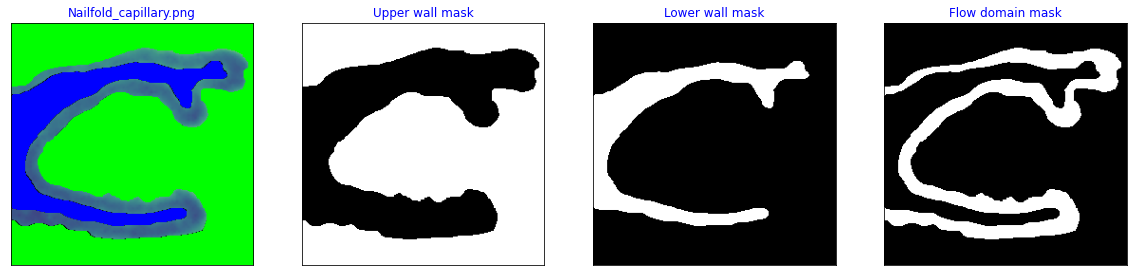

Check the masks: 
upper wall (min, max) = (tensor(0.), tensor(1.)), 
lower wall (min, max) = (tensor(0.), tensor(1.)), 
flow domain (min, max) = (tensor(0.), tensor(1.)),


In [21]:
labeledImage = Image.open(imgPath/imgList[imgNo]) #open image
labeledImage = torch.tensor(np.uint8(labeledImage.resize((SIZE,SIZE),resample=3)))[:,:,:-1] #open image

tmpImage = torch.ones(labeledImage.shape)

upperWallMask = (labeledImage == (tmpImage*UP_COLOR)).float().sum(axis=2)
invUpperWallMask = torch.clone(upperWallMask)
upperWallMask[upperWallMask < 3] = 0
upperWallMask[upperWallMask == 3] = 1
invUpperWallMask[invUpperWallMask < 3] = 1
invUpperWallMask[invUpperWallMask == 3] = 0

lowerWallMask = (labeledImage == (tmpImage*LOW_COLOR)).float().sum(axis=2)
invLowerWallMask = torch.clone(lowerWallMask)
lowerWallMask[lowerWallMask < 3] = 0
lowerWallMask[lowerWallMask == 3] = 1
invLowerWallMask[invLowerWallMask < 3] = 1
invLowerWallMask[invLowerWallMask == 3] = 0

flowDomainMask = (invLowerWallMask + invUpperWallMask)/2
flowDomainMask[flowDomainMask<1] = 0

#Visualization
nr=1
nc=4
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(labeledImage)
plt.xticks([])
plt.yticks([])
plt.title(imgList[imgNo], color='b')

plt.subplot(nr,nc,2)
plt.imshow(upperWallMask, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Upper wall mask", color='b')

plt.subplot(nr,nc,3)
plt.imshow(lowerWallMask, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Lower wall mask", color='b')

plt.subplot(nr,nc,4)
plt.imshow(flowDomainMask, cmap = 'gray')
plt.xticks([])
plt.yticks([])
plt.title("Flow domain mask", color='b')

plt.show()

print (f'Check the masks: \nupper wall (min, max) = {upperWallMask.min(), upperWallMask.max()}, \nlower wall (min, max) = {lowerWallMask.min(), lowerWallMask.max()}, \nflow domain (min, max) = {flowDomainMask.min(), flowDomainMask.max()},')

## Kinematic properties
The velocity is equal to zero on all the surfaces. The flow rate is given and equal to Q.

1. Flow function initialization

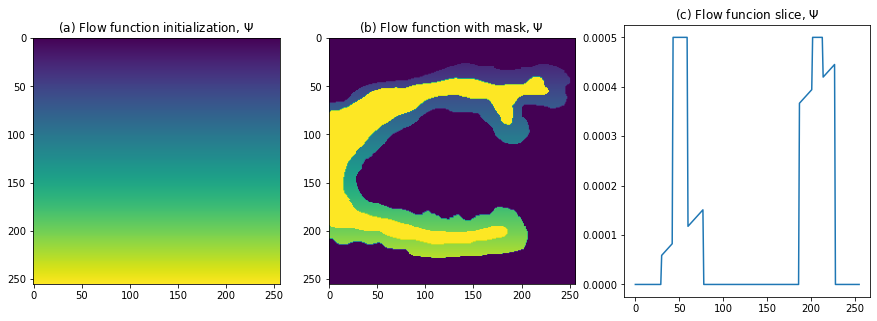

In [22]:
#Initialization
psi0 = (torch.linspace(0, Q, SIZE, dtype=torch.float32) * torch.ones(SIZE,SIZE)).T #raw Psi0 function
psi0_masked = psi0 *flowDomainMask + (lowerWallMask*Q)

#Visualization
nr=1
nc=3
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(psi0)
plt.title('(a) Flow function initialization, $\Psi$')

plt.subplot(nr,nc,2)
plt.imshow(psi0_masked)
plt.title('(b) Flow function with mask, $\Psi$')

plt.subplot(nr,nc,3)
plt.plot(psi0_masked[:,sp])
plt.title('(c) Flow funcion slice, $\Psi$')

plt.show()

2. Velocity field initialization

In [23]:
# v1, v2 = velocityDistr(psi0_masked, DX1N, DX2N, LIM1, LIM2)

# #Visualization
# nr=2
# nc=2
# fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
# plt.subplot(nr,nc,1)
# plt.imshow(psi0_masked)
# plt.title('Flow function, Psi')

# plt.subplot(nr,nc,2)
# #coordinates are negative in meshgrid for the better visualisation
# vector_plot(np.meshgrid(-X1N,-X2N), [np.array(v1.cpu()),np.array(v2.cpu())],FIGSIZE, 'Velocity, V = [v1, v2]', vps)
# plt.xticks([])
# plt.yticks([])

# plt.subplot(nr,nc,3)
# plt.plot(psi0_masked[:,sp])
# plt.grid(True)
# plt.title('Flow function, Psi (vertical slice)')

# plt.subplot(nr,nc,4)
# plt.plot(v1[:,sp].cpu())
# plt.grid(True)
# plt.title('v1 (vertical slice)')

# plt.show()

In [24]:
# # Check the flow rate
# Qch = torch.trapz(v1.t()) * DX1N * L

# fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
# plt.plot(Qch.cpu())
# plt.title(f'Flow rate through the vertical slices of the flow domain of size L x L = {L} x {L} \nshould be equal to Q = {Q}')
# plt.show()

## Create model
Unet architecture [2] is used

In [25]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=4, use_bn=True):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1", use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2", use_bn=use_bn)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3", use_bn=use_bn)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4", use_bn=use_bn)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck", use_bn=use_bn)

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4", use_bn=use_bn)
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3", use_bn=use_bn)
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2", use_bn=use_bn)
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1", use_bn=use_bn)
        self.decoder0 = UNet._block(features, features, name="dec1", use_bn=use_bn)
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x / Q - 0.5)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec0 = self.decoder0(dec1)
        return torch.sigmoid(self.conv(dec0))*Q

    @staticmethod
    def _block(in_channels, features, name, use_bn):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    *[(name + "norm1", nn.BatchNorm2d(num_features=features)),
                      (name + "relu1", nn.Sigmoid())][0 if use_bn else 1:],
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=not use_bn,
                        ),
                    ),
                    *[(name + "norm2", nn.BatchNorm2d(num_features=features)),
                      (name + "relu2", nn.Sigmoid())][0 if use_bn else 1:],
                ]
            )
        )
    
    
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        for i in range(hidden_layers):
            if not i:
                layers += [nn.Linear(input_size, hidden_layer_size, bias=True),
                           nn.Tanh()]
                torch.nn.init.xavier_normal_(layers[-2].weight)
            else:
                layers += [nn.Linear(hidden_layer_size, hidden_layer_size, bias=True),
                           nn.Tanh()]
                torch.nn.init.xavier_normal_(layers[-2].weight)
            
        layers.append(nn.Linear(hidden_layer_size, 1, bias=True))
        torch.nn.init.xavier_normal_(layers[-1].weight)
                      
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        y = torch.sigmoid(self.mlp(x - 0.5)) * Q
        return y.reshape(SIZE, SIZE)

    
def power_loss(psi, x1, x2):
    psi_masked = (psi)
    
    psi_l = psi[lowerWallMask == 1]
    psi_u = psi[upperWallMask == 1]
    
    v1,v2 = velocityDistr(psi_masked, x1, x2, LIM1, LIM2)

    xi11, xi12, xi22, EtaEta = TksiDistr(v1, v2, x1, x2, LIM1, LIM2)

    int1EtaEta = torch.trapz(EtaEta.reshape(SIZE, SIZE) + v1.reshape(SIZE, SIZE)*Fm[0]+v2.reshape(SIZE, SIZE)*Fm[1])

    int2EtaEta = torch.trapz(int1EtaEta)
    out = 0.5*MU*s*int2EtaEta #doublelIntegral(0.5*mu*EtaEta,lim1,lim2) #loss
    
    return out + MSE(psi_u, torch.zeros_like(psi_u)) * 1000000 + MSE(psi_l, torch.ones_like(psi_l) * Q) * 1000000

## Training

In [26]:
start_time = time.time()

hyperparams: 
 learning_rate 0.001, scheduler None, scheduler_factor 0.1, scheduler_patience 200, hidden_layers 10, hidden_neurons 32, Early_stop_patience 1000, Decay 0, optimizer Adam


Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch 1/10000, loss = 498.5770263671875
epoch 2/10000, loss = 494.16815185546875
epoch 3/10000, loss = 489.1544189453125
epoch 4/10000, loss = 483.1539611816406
epoch 5/10000, loss = 475.8560791015625
epoch 6/10000, loss = 467.0853271484375
epoch 7/10000, loss = 456.8686828613281
epoch 8/10000, loss = 445.4230041503906
epoch 9/10000, loss = 433.1063232421875
epoch 10/10000, loss = 420.4432373046875
epoch 11/10000, loss = 408.1217041015625
epoch 12/10000, loss = 396.77642822265625
epoch 13/10000, loss = 386.77264404296875
epoch 14/10000, loss = 378.15631103515625
epoch 15/10000, loss = 370.7157897949219
epoch 16/10000, loss = 364.17919921875
epoch 17/10000, loss = 358.4254150390625
epoch 18/10000, loss = 353.472900390625
epoch 19/10000, loss = 349.1908874511719
epoch 20/10000, loss = 345.32537841796875
epoch 21/10000, loss = 341.96087646484375
epoch 22/10000, loss = 339.05303955078125
epoch 23/10000, loss = 336.427001953125
epoch 24/10000, loss = 334.18646240234375
epoch 25/10000, loss 

epoch 199/10000, loss = 319.9298095703125
epoch 200/10000, loss = 319.91961669921875
epoch 201/10000, loss = 319.9093933105469
epoch 202/10000, loss = 319.8990173339844
epoch 203/10000, loss = 319.88861083984375
epoch 204/10000, loss = 319.8780822753906
epoch 205/10000, loss = 319.8675231933594
epoch 206/10000, loss = 319.8567810058594
epoch 207/10000, loss = 319.84600830078125
epoch 208/10000, loss = 319.8351135253906
epoch 209/10000, loss = 319.8241271972656
epoch 210/10000, loss = 319.81298828125
epoch 211/10000, loss = 319.80169677734375
epoch 212/10000, loss = 319.7903137207031
epoch 213/10000, loss = 319.7787780761719
epoch 214/10000, loss = 319.76708984375
epoch 215/10000, loss = 319.75531005859375
epoch 216/10000, loss = 319.74334716796875
epoch 217/10000, loss = 319.731201171875
epoch 218/10000, loss = 319.7188720703125
epoch 219/10000, loss = 319.70635986328125
epoch 220/10000, loss = 319.69366455078125
epoch 221/10000, loss = 319.6806945800781
epoch 222/10000, loss = 319.667

epoch 393/10000, loss = 233.65701293945312
epoch 394/10000, loss = 233.04534912109375
epoch 395/10000, loss = 232.40615844726562
epoch 396/10000, loss = 231.73388671875
epoch 397/10000, loss = 231.02923583984375
epoch 398/10000, loss = 230.28912353515625
epoch 399/10000, loss = 229.50909423828125
epoch 400/10000, loss = 228.6888885498047
epoch 401/10000, loss = 227.82443237304688
epoch 402/10000, loss = 226.91326904296875
epoch 403/10000, loss = 225.95419311523438
epoch 404/10000, loss = 224.9410400390625
epoch 405/10000, loss = 223.86917114257812
epoch 406/10000, loss = 222.7291259765625
epoch 407/10000, loss = 221.49989318847656
epoch 408/10000, loss = 220.1472625732422
epoch 409/10000, loss = 218.61407470703125
epoch 410/10000, loss = 216.82704162597656
epoch 411/10000, loss = 214.72415161132812
epoch 412/10000, loss = 212.32281494140625
epoch 413/10000, loss = 209.63357543945312
epoch 414/10000, loss = 206.53265380859375
epoch 415/10000, loss = 202.94003295898438
epoch 416/10000, l

epoch 585/10000, loss = 14.429460525512695
epoch 586/10000, loss = 14.380294799804688
epoch 587/10000, loss = 14.33164119720459
epoch 588/10000, loss = 14.268341064453125
epoch 589/10000, loss = 14.205684661865234
epoch 590/10000, loss = 14.144436836242676
epoch 591/10000, loss = 14.082988739013672
epoch 592/10000, loss = 14.02762222290039
epoch 593/10000, loss = 13.970641136169434
epoch 594/10000, loss = 13.90977668762207
epoch 595/10000, loss = 13.85009479522705
epoch 596/10000, loss = 13.788528442382812
epoch 597/10000, loss = 13.727981567382812
epoch 598/10000, loss = 13.672447204589844
epoch 599/10000, loss = 13.615524291992188
epoch 600/10000, loss = 13.55638313293457
epoch 601/10000, loss = 13.496665954589844
epoch 602/10000, loss = 13.43537712097168
epoch 603/10000, loss = 13.376372337341309
epoch 604/10000, loss = 13.318893432617188
epoch 605/10000, loss = 13.259271621704102
epoch 606/10000, loss = 13.19903564453125
epoch 607/10000, loss = 13.138262748718262
epoch 608/10000, l

epoch 779/10000, loss = 5.760830879211426
epoch 780/10000, loss = 5.746018409729004
epoch 781/10000, loss = 5.731316089630127
epoch 782/10000, loss = 5.716724395751953
epoch 783/10000, loss = 5.70224142074585
epoch 784/10000, loss = 5.687863826751709
epoch 785/10000, loss = 5.6735920906066895
epoch 786/10000, loss = 5.659424781799316
epoch 787/10000, loss = 5.645357131958008
epoch 788/10000, loss = 5.631390571594238
epoch 789/10000, loss = 5.617524147033691
epoch 790/10000, loss = 5.603754997253418
epoch 791/10000, loss = 5.590083599090576
epoch 792/10000, loss = 5.576508045196533
epoch 793/10000, loss = 5.563024520874023
epoch 794/10000, loss = 5.5496344566345215
epoch 795/10000, loss = 5.536336421966553
epoch 796/10000, loss = 5.523129940032959
epoch 797/10000, loss = 5.510011672973633
epoch 798/10000, loss = 5.496981620788574
epoch 799/10000, loss = 5.484039783477783
epoch 800/10000, loss = 5.471182823181152
epoch 801/10000, loss = 5.458411693572998
epoch 802/10000, loss = 5.4457249

epoch 975/10000, loss = 4.050274848937988
epoch 976/10000, loss = 4.045251369476318
epoch 977/10000, loss = 4.040249347686768
epoch 978/10000, loss = 4.035272121429443
epoch 979/10000, loss = 4.030315399169922
epoch 980/10000, loss = 4.025383472442627
epoch 981/10000, loss = 4.020473480224609
epoch 982/10000, loss = 4.015584468841553
epoch 983/10000, loss = 4.0107197761535645
epoch 984/10000, loss = 4.005875587463379
epoch 985/10000, loss = 4.0010528564453125
epoch 986/10000, loss = 3.9962539672851562
epoch 987/10000, loss = 3.991474151611328
epoch 988/10000, loss = 3.986717700958252
epoch 989/10000, loss = 3.9819817543029785
epoch 990/10000, loss = 3.977266550064087
epoch 991/10000, loss = 3.9725723266601562
epoch 992/10000, loss = 3.9678993225097656
epoch 993/10000, loss = 3.9632456302642822
epoch 994/10000, loss = 3.9586148262023926
epoch 995/10000, loss = 3.9540023803710938
epoch 996/10000, loss = 3.9494099617004395
epoch 997/10000, loss = 3.944838285446167
epoch 998/10000, loss = 

epoch 1164/10000, loss = 3.3550705909729004
epoch 1165/10000, loss = 3.3520750999450684
epoch 1166/10000, loss = 3.3490819931030273
epoch 1167/10000, loss = 3.346090316772461
epoch 1168/10000, loss = 3.3431026935577393
epoch 1169/10000, loss = 3.340116500854492
epoch 1170/10000, loss = 3.3371338844299316
epoch 1171/10000, loss = 3.334153413772583
epoch 1172/10000, loss = 3.331174373626709
epoch 1173/10000, loss = 3.3281984329223633
epoch 1174/10000, loss = 3.325223922729492
epoch 1175/10000, loss = 3.322251796722412
epoch 1176/10000, loss = 3.319282054901123
epoch 1177/10000, loss = 3.316315174102783
epoch 1178/10000, loss = 3.313350200653076
epoch 1179/10000, loss = 3.3103885650634766
epoch 1180/10000, loss = 3.3074259757995605
epoch 1181/10000, loss = 3.3044674396514893
epoch 1182/10000, loss = 3.301511287689209
epoch 1183/10000, loss = 3.2985572814941406
epoch 1184/10000, loss = 3.2956035137176514
epoch 1185/10000, loss = 3.292653799057007
epoch 1186/10000, loss = 3.289703845977783


epoch 1353/10000, loss = 2.8142194747924805
epoch 1354/10000, loss = 2.8114278316497803
epoch 1355/10000, loss = 2.808635711669922
epoch 1356/10000, loss = 2.805844306945801
epoch 1357/10000, loss = 2.803053379058838
epoch 1358/10000, loss = 2.8002631664276123
epoch 1359/10000, loss = 2.7974720001220703
epoch 1360/10000, loss = 2.7946810722351074
epoch 1361/10000, loss = 2.791891574859619
epoch 1362/10000, loss = 2.7891016006469727
epoch 1363/10000, loss = 2.7863121032714844
epoch 1364/10000, loss = 2.7835230827331543
epoch 1365/10000, loss = 2.780734062194824
epoch 1366/10000, loss = 2.7779457569122314
epoch 1367/10000, loss = 2.7751572132110596
epoch 1368/10000, loss = 2.772369146347046
epoch 1369/10000, loss = 2.7695822715759277
epoch 1370/10000, loss = 2.7667953968048096
epoch 1371/10000, loss = 2.764008045196533
epoch 1372/10000, loss = 2.7612218856811523
epoch 1373/10000, loss = 2.758434295654297
epoch 1374/10000, loss = 2.7556490898132324
epoch 1375/10000, loss = 2.7528634071350

epoch 1542/10000, loss = 2.301439046859741
epoch 1543/10000, loss = 2.298921823501587
epoch 1544/10000, loss = 2.2964084148406982
epoch 1545/10000, loss = 2.2938990592956543
epoch 1546/10000, loss = 2.2913930416107178
epoch 1547/10000, loss = 2.288891553878784
epoch 1548/10000, loss = 2.286393642425537
epoch 1549/10000, loss = 2.2839009761810303
epoch 1550/10000, loss = 2.2814114093780518
epoch 1551/10000, loss = 2.2789266109466553
epoch 1552/10000, loss = 2.2764453887939453
epoch 1553/10000, loss = 2.2739694118499756
epoch 1554/10000, loss = 2.2714972496032715
epoch 1555/10000, loss = 2.2690300941467285
epoch 1556/10000, loss = 2.2665672302246094
epoch 1557/10000, loss = 2.264108896255493
epoch 1558/10000, loss = 2.2616536617279053
epoch 1559/10000, loss = 2.2592039108276367
epoch 1560/10000, loss = 2.256758689880371
epoch 1561/10000, loss = 2.2543184757232666
epoch 1562/10000, loss = 2.251882553100586
epoch 1563/10000, loss = 2.249451160430908
epoch 1564/10000, loss = 2.2470242977142

epoch 1731/10000, loss = 1.9266736507415771
epoch 1732/10000, loss = 1.925289273262024
epoch 1733/10000, loss = 1.9239110946655273
epoch 1734/10000, loss = 1.9225378036499023
epoch 1735/10000, loss = 1.9211716651916504
epoch 1736/10000, loss = 1.9198099374771118
epoch 1737/10000, loss = 1.9184538125991821
epoch 1738/10000, loss = 1.9171035289764404
epoch 1739/10000, loss = 1.9157588481903076
epoch 1740/10000, loss = 1.9144186973571777
epoch 1741/10000, loss = 1.9130839109420776
epoch 1742/10000, loss = 1.911754846572876
epoch 1743/10000, loss = 1.9104310274124146
epoch 1744/10000, loss = 1.9091126918792725
epoch 1745/10000, loss = 1.9077996015548706
epoch 1746/10000, loss = 1.9064913988113403
epoch 1747/10000, loss = 1.9051880836486816
epoch 1748/10000, loss = 1.9038901329040527
epoch 1749/10000, loss = 1.9025976657867432
epoch 1750/10000, loss = 1.9013100862503052
epoch 1751/10000, loss = 1.9000275135040283
epoch 1752/10000, loss = 1.8987500667572021
epoch 1753/10000, loss = 1.8974777

epoch 1919/10000, loss = 1.7334812879562378
epoch 1920/10000, loss = 1.7326722145080566
epoch 1921/10000, loss = 1.7318637371063232
epoch 1922/10000, loss = 1.7310575246810913
epoch 1923/10000, loss = 1.7302519083023071
epoch 1924/10000, loss = 1.7294470071792603
epoch 1925/10000, loss = 1.7286443710327148
epoch 1926/10000, loss = 1.727842092514038
epoch 1927/10000, loss = 1.7270407676696777
epoch 1928/10000, loss = 1.7262415885925293
epoch 1929/10000, loss = 1.725442886352539
epoch 1930/10000, loss = 1.7246456146240234
epoch 1931/10000, loss = 1.7238489389419556
epoch 1932/10000, loss = 1.7230538129806519
epoch 1933/10000, loss = 1.722259283065796
epoch 1934/10000, loss = 1.7214655876159668
epoch 1935/10000, loss = 1.720674753189087
epoch 1936/10000, loss = 1.719882845878601
epoch 1937/10000, loss = 1.7190932035446167
epoch 1938/10000, loss = 1.7183048725128174
epoch 1939/10000, loss = 1.717517375946045
epoch 1940/10000, loss = 1.7167302370071411
epoch 1941/10000, loss = 1.71594452857

epoch 2107/10000, loss = 1.5952122211456299
epoch 2108/10000, loss = 1.5945255756378174
epoch 2109/10000, loss = 1.5938392877578735
epoch 2110/10000, loss = 1.5931535959243774
epoch 2111/10000, loss = 1.59246826171875
epoch 2112/10000, loss = 1.5917829275131226
epoch 2113/10000, loss = 1.5910990238189697
epoch 2114/10000, loss = 1.59041428565979
epoch 2115/10000, loss = 1.5897307395935059
epoch 2116/10000, loss = 1.5890471935272217
epoch 2117/10000, loss = 1.5883634090423584
epoch 2118/10000, loss = 1.5876812934875488
epoch 2119/10000, loss = 1.586998462677002
epoch 2120/10000, loss = 1.5863163471221924
epoch 2121/10000, loss = 1.585634708404541
epoch 2122/10000, loss = 1.5849539041519165
epoch 2123/10000, loss = 1.5842723846435547
epoch 2124/10000, loss = 1.5835920572280884
epoch 2125/10000, loss = 1.5829113721847534
epoch 2126/10000, loss = 1.582230806350708
epoch 2127/10000, loss = 1.5815515518188477
epoch 2128/10000, loss = 1.5808725357055664
epoch 2129/10000, loss = 1.580193519592

epoch 2296/10000, loss = 1.4709467887878418
epoch 2297/10000, loss = 1.4703134298324585
epoch 2298/10000, loss = 1.4696805477142334
epoch 2299/10000, loss = 1.46904718875885
epoch 2300/10000, loss = 1.4684146642684937
epoch 2301/10000, loss = 1.4677826166152954
epoch 2302/10000, loss = 1.4671506881713867
epoch 2303/10000, loss = 1.466518759727478
epoch 2304/10000, loss = 1.4658868312835693
epoch 2305/10000, loss = 1.4652550220489502
epoch 2306/10000, loss = 1.4646244049072266
epoch 2307/10000, loss = 1.4639933109283447
epoch 2308/10000, loss = 1.4633619785308838
epoch 2309/10000, loss = 1.4627317190170288
epoch 2310/10000, loss = 1.4621007442474365
epoch 2311/10000, loss = 1.4614704847335815
epoch 2312/10000, loss = 1.460840106010437
epoch 2313/10000, loss = 1.4602102041244507
epoch 2314/10000, loss = 1.4595805406570435
epoch 2315/10000, loss = 1.4589511156082153
epoch 2316/10000, loss = 1.4583219289779663
epoch 2317/10000, loss = 1.4576926231384277
epoch 2318/10000, loss = 1.457063436

epoch 2484/10000, loss = 1.3543622493743896
epoch 2485/10000, loss = 1.3537477254867554
epoch 2486/10000, loss = 1.353132963180542
epoch 2487/10000, loss = 1.3525183200836182
epoch 2488/10000, loss = 1.3519033193588257
epoch 2489/10000, loss = 1.3512885570526123
epoch 2490/10000, loss = 1.3506734371185303
epoch 2491/10000, loss = 1.3500585556030273
epoch 2492/10000, loss = 1.3494439125061035
epoch 2493/10000, loss = 1.3488287925720215
epoch 2494/10000, loss = 1.3482134342193604
epoch 2495/10000, loss = 1.347598671913147
epoch 2496/10000, loss = 1.3469836711883545
epoch 2497/10000, loss = 1.3463687896728516
epoch 2498/10000, loss = 1.3457529544830322
epoch 2499/10000, loss = 1.3451381921768188
epoch 2500/10000, loss = 1.34452223777771
epoch 2501/10000, loss = 1.343907117843628
epoch 2502/10000, loss = 1.343291997909546
epoch 2503/10000, loss = 1.342676043510437
epoch 2504/10000, loss = 1.3420603275299072
epoch 2505/10000, loss = 1.341444492340088
epoch 2506/10000, loss = 1.3408290147781

epoch 2673/10000, loss = 1.235827088356018
epoch 2674/10000, loss = 1.2351809740066528
epoch 2675/10000, loss = 1.234534740447998
epoch 2676/10000, loss = 1.2338879108428955
epoch 2677/10000, loss = 1.2332414388656616
epoch 2678/10000, loss = 1.2325941324234009
epoch 2679/10000, loss = 1.2319473028182983
epoch 2680/10000, loss = 1.2312992811203003
epoch 2681/10000, loss = 1.2306519746780396
epoch 2682/10000, loss = 1.2300045490264893
epoch 2683/10000, loss = 1.2293566465377808
epoch 2684/10000, loss = 1.2287077903747559
epoch 2685/10000, loss = 1.22805917263031
epoch 2686/10000, loss = 1.2274103164672852
epoch 2687/10000, loss = 1.226762056350708
epoch 2688/10000, loss = 1.2261128425598145
epoch 2689/10000, loss = 1.2254638671875
epoch 2690/10000, loss = 1.2248139381408691
epoch 2691/10000, loss = 1.2241644859313965
epoch 2692/10000, loss = 1.2235146760940552
epoch 2693/10000, loss = 1.2228643894195557
epoch 2694/10000, loss = 1.2222143411636353
epoch 2695/10000, loss = 1.2215636968612

epoch 2861/10000, loss = 1.1130399703979492
epoch 2862/10000, loss = 1.1124017238616943
epoch 2863/10000, loss = 1.11176335811615
epoch 2864/10000, loss = 1.1111263036727905
epoch 2865/10000, loss = 1.1104893684387207
epoch 2866/10000, loss = 1.1098527908325195
epoch 2867/10000, loss = 1.109216570854187
epoch 2868/10000, loss = 1.1085810661315918
epoch 2869/10000, loss = 1.1079459190368652
epoch 2870/10000, loss = 1.1073108911514282
epoch 2871/10000, loss = 1.1066768169403076
epoch 2872/10000, loss = 1.1060428619384766
epoch 2873/10000, loss = 1.1054102182388306
epoch 2874/10000, loss = 1.1047773361206055
epoch 2875/10000, loss = 1.1041449308395386
epoch 2876/10000, loss = 1.103513240814209
epoch 2877/10000, loss = 1.1028820276260376
epoch 2878/10000, loss = 1.1022518873214722
epoch 2879/10000, loss = 1.1016219854354858
epoch 2880/10000, loss = 1.100992202758789
epoch 2881/10000, loss = 1.1003633737564087
epoch 2882/10000, loss = 1.099734902381897
epoch 2883/10000, loss = 1.09910690784

epoch 3049/10000, loss = 1.0047682523727417
epoch 3050/10000, loss = 1.0042665004730225
epoch 3051/10000, loss = 1.0037651062011719
epoch 3052/10000, loss = 1.003264307975769
epoch 3053/10000, loss = 1.0027650594711304
epoch 3054/10000, loss = 1.0022661685943604
epoch 3055/10000, loss = 1.0017679929733276
epoch 3056/10000, loss = 1.0012710094451904
epoch 3057/10000, loss = 1.0007742643356323
epoch 3058/10000, loss = 1.0002785921096802
epoch 3059/10000, loss = 0.9997838139533997
epoch 3060/10000, loss = 0.9992899298667908
epoch 3061/10000, loss = 0.9987969994544983
epoch 3062/10000, loss = 0.9983044862747192
epoch 3063/10000, loss = 0.9978122711181641
epoch 3064/10000, loss = 0.9973214268684387
epoch 3065/10000, loss = 0.9968312382698059
epoch 3066/10000, loss = 0.9963424205780029
epoch 3067/10000, loss = 0.9958539605140686
epoch 3068/10000, loss = 0.9953667521476746
epoch 3069/10000, loss = 0.994879424571991
epoch 3070/10000, loss = 0.9943934082984924
epoch 3071/10000, loss = 0.9939084

epoch 3236/10000, loss = 0.9248236417770386
epoch 3237/10000, loss = 0.9244668483734131
epoch 3238/10000, loss = 0.9241106510162354
epoch 3239/10000, loss = 0.9237546920776367
epoch 3240/10000, loss = 0.9233987331390381
epoch 3241/10000, loss = 0.9230441451072693
epoch 3242/10000, loss = 0.9226904511451721
epoch 3243/10000, loss = 0.9223370552062988
epoch 3244/10000, loss = 0.9219839572906494
epoch 3245/10000, loss = 0.9216321110725403
epoch 3246/10000, loss = 0.9212809801101685
epoch 3247/10000, loss = 0.9209296703338623
epoch 3248/10000, loss = 0.9205793142318726
epoch 3249/10000, loss = 0.9202293753623962
epoch 3250/10000, loss = 0.9198802709579468
epoch 3251/10000, loss = 0.9195312857627869
epoch 3252/10000, loss = 0.919183611869812
epoch 3253/10000, loss = 0.9188361167907715
epoch 3254/10000, loss = 0.9184890389442444
epoch 3255/10000, loss = 0.9181428551673889
epoch 3256/10000, loss = 0.9177972078323364
epoch 3257/10000, loss = 0.9174519777297974
epoch 3258/10000, loss = 0.917107

epoch 3424/10000, loss = 0.8658746480941772
epoch 3425/10000, loss = 0.865591824054718
epoch 3426/10000, loss = 0.8653095364570618
epoch 3427/10000, loss = 0.865027129650116
epoch 3428/10000, loss = 0.8647451400756836
epoch 3429/10000, loss = 0.8644635677337646
epoch 3430/10000, loss = 0.8641823530197144
epoch 3431/10000, loss = 0.8639011383056641
epoch 3432/10000, loss = 0.8636199831962585
epoch 3433/10000, loss = 0.8633395433425903
epoch 3434/10000, loss = 0.8630589842796326
epoch 3435/10000, loss = 0.862778902053833
epoch 3436/10000, loss = 0.8624992370605469
epoch 3437/10000, loss = 0.8622201085090637
epoch 3438/10000, loss = 0.8619403839111328
epoch 3439/10000, loss = 0.861661434173584
epoch 3440/10000, loss = 0.8613824844360352
epoch 3441/10000, loss = 0.861103892326355
epoch 3442/10000, loss = 0.8608259558677673
epoch 3443/10000, loss = 0.8605480790138245
epoch 3444/10000, loss = 0.8602708578109741
epoch 3445/10000, loss = 0.8599936366081238
epoch 3446/10000, loss = 0.8597162365

epoch 3611/10000, loss = 0.8350815176963806
epoch 3612/10000, loss = 0.8425524234771729
epoch 3613/10000, loss = 0.8666436076164246
epoch 3614/10000, loss = 0.8681216239929199
epoch 3615/10000, loss = 0.9012284874916077
epoch 3616/10000, loss = 0.8690947890281677
epoch 3617/10000, loss = 0.8569374084472656
epoch 3618/10000, loss = 0.8246735334396362
epoch 3619/10000, loss = 0.8242308497428894
epoch 3620/10000, loss = 0.8466490507125854
epoch 3621/10000, loss = 0.8467774987220764
epoch 3622/10000, loss = 0.8439820408821106
epoch 3623/10000, loss = 0.8233923316001892
epoch 3624/10000, loss = 0.81778484582901
epoch 3625/10000, loss = 0.825853168964386
epoch 3626/10000, loss = 0.835845947265625
epoch 3627/10000, loss = 0.8527701497077942
epoch 3628/10000, loss = 0.849031925201416
epoch 3629/10000, loss = 0.8627772927284241
epoch 3630/10000, loss = 0.848935067653656
epoch 3631/10000, loss = 0.850363552570343
epoch 3632/10000, loss = 0.8305668830871582
epoch 3633/10000, loss = 0.819742023944

epoch 3798/10000, loss = 0.7879845499992371
epoch 3799/10000, loss = 0.7863571643829346
epoch 3800/10000, loss = 0.7836847305297852
epoch 3801/10000, loss = 0.7819489240646362
epoch 3802/10000, loss = 0.7815272212028503
epoch 3803/10000, loss = 0.7821293473243713
epoch 3804/10000, loss = 0.7832501530647278
epoch 3805/10000, loss = 0.7839233875274658
epoch 3806/10000, loss = 0.7845577001571655
epoch 3807/10000, loss = 0.783880352973938
epoch 3808/10000, loss = 0.7830652594566345
epoch 3809/10000, loss = 0.7816354036331177
epoch 3810/10000, loss = 0.7805454730987549
epoch 3811/10000, loss = 0.7798927426338196
epoch 3812/10000, loss = 0.7796909213066101
epoch 3813/10000, loss = 0.7798243761062622
epoch 3814/10000, loss = 0.7800853252410889
epoch 3815/10000, loss = 0.7804687023162842
epoch 3816/10000, loss = 0.7805805206298828
epoch 3817/10000, loss = 0.7806291580200195
epoch 3818/10000, loss = 0.7801921367645264
epoch 3819/10000, loss = 0.7797597646713257
epoch 3820/10000, loss = 0.779123

epoch 3986/10000, loss = 1.6613017320632935
epoch 3987/10000, loss = 1.5997331142425537
epoch 3988/10000, loss = 1.518635869026184
epoch 3989/10000, loss = 1.4706028699874878
epoch 3990/10000, loss = 1.451729655265808
epoch 3991/10000, loss = 1.39104163646698
epoch 3992/10000, loss = 1.3119229078292847
epoch 3993/10000, loss = 1.2945436239242554
epoch 3994/10000, loss = 1.3068280220031738
epoch 3995/10000, loss = 1.2703287601470947
epoch 3996/10000, loss = 1.2062205076217651
epoch 3997/10000, loss = 1.1739565134048462
epoch 3998/10000, loss = 1.1515326499938965
epoch 3999/10000, loss = 1.1196216344833374
epoch 4000/10000, loss = 1.1041911840438843
epoch 4001/10000, loss = 1.10832679271698
epoch 4002/10000, loss = 1.109897255897522
epoch 4003/10000, loss = 1.096814513206482
epoch 4004/10000, loss = 1.0746673345565796
epoch 4005/10000, loss = 1.0567482709884644
epoch 4006/10000, loss = 1.0475096702575684
epoch 4007/10000, loss = 1.0367381572723389
epoch 4008/10000, loss = 1.0236761569976

epoch 4173/10000, loss = 0.8221582174301147
epoch 4174/10000, loss = 0.8218581676483154
epoch 4175/10000, loss = 0.8215605020523071
epoch 4176/10000, loss = 0.8212645053863525
epoch 4177/10000, loss = 0.8209711313247681
epoch 4178/10000, loss = 0.820679783821106
epoch 4179/10000, loss = 0.8203899264335632
epoch 4180/10000, loss = 0.8201028108596802
epoch 4181/10000, loss = 0.8198168277740479
epoch 4182/10000, loss = 0.8195334076881409
epoch 4183/10000, loss = 0.8192517757415771
epoch 4184/10000, loss = 0.8189718723297119
epoch 4185/10000, loss = 0.8186938762664795
epoch 4186/10000, loss = 0.8184176087379456
epoch 4187/10000, loss = 0.8181436657905579
epoch 4188/10000, loss = 0.8178712129592896
epoch 4189/10000, loss = 0.817600429058075
epoch 4190/10000, loss = 0.8173314929008484
epoch 4191/10000, loss = 0.8170642256736755
epoch 4192/10000, loss = 0.8167986869812012
epoch 4193/10000, loss = 0.8165348768234253
epoch 4194/10000, loss = 0.8162728548049927
epoch 4195/10000, loss = 0.8160121

epoch 4360/10000, loss = 0.7859910130500793
epoch 4361/10000, loss = 0.7858545780181885
epoch 4362/10000, loss = 0.7857179641723633
epoch 4363/10000, loss = 0.7855821847915649
epoch 4364/10000, loss = 0.7854462265968323
epoch 4365/10000, loss = 0.785311222076416
epoch 4366/10000, loss = 0.7851763367652893
epoch 4367/10000, loss = 0.7850415706634521
epoch 4368/10000, loss = 0.7849072217941284
epoch 4369/10000, loss = 0.7847732901573181
epoch 4370/10000, loss = 0.7846394777297974
epoch 4371/10000, loss = 0.7845059633255005
epoch 4372/10000, loss = 0.7843732237815857
epoch 4373/10000, loss = 0.7842406630516052
epoch 4374/10000, loss = 0.7841081619262695
epoch 4375/10000, loss = 0.7839764356613159
epoch 4376/10000, loss = 0.7838449478149414
epoch 4377/10000, loss = 0.7837141752243042
epoch 4378/10000, loss = 0.7835829854011536
epoch 4379/10000, loss = 0.7834526896476746
epoch 4380/10000, loss = 0.7833219766616821
epoch 4381/10000, loss = 0.7831922173500061
epoch 4382/10000, loss = 0.783062

epoch 4547/10000, loss = 0.762370765209198
epoch 4548/10000, loss = 0.7622588276863098
epoch 4549/10000, loss = 0.7621468901634216
epoch 4550/10000, loss = 0.7620353698730469
epoch 4551/10000, loss = 0.7619236707687378
epoch 4552/10000, loss = 0.7618128657341003
epoch 4553/10000, loss = 0.7617020010948181
epoch 4554/10000, loss = 0.7615911960601807
epoch 4555/10000, loss = 0.7614808678627014
epoch 4556/10000, loss = 0.7613706588745117
epoch 4557/10000, loss = 0.761260986328125
epoch 4558/10000, loss = 0.7611515522003174
epoch 4559/10000, loss = 0.7610421180725098
epoch 4560/10000, loss = 0.7609329223632812
epoch 4561/10000, loss = 0.7608242630958557
epoch 4562/10000, loss = 0.7607160210609436
epoch 4563/10000, loss = 0.7606073617935181
epoch 4564/10000, loss = 0.7604998350143433
epoch 4565/10000, loss = 0.7603918313980103
epoch 4566/10000, loss = 0.7602843046188354
epoch 4567/10000, loss = 0.7601767778396606
epoch 4568/10000, loss = 0.7600700855255127
epoch 4569/10000, loss = 0.7599632

epoch 4734/10000, loss = 0.7448642253875732
epoch 4735/10000, loss = 0.7447844743728638
epoch 4736/10000, loss = 0.7447047233581543
epoch 4737/10000, loss = 0.7446255683898926
epoch 4738/10000, loss = 0.7445459365844727
epoch 4739/10000, loss = 0.7444665431976318
epoch 4740/10000, loss = 0.7443874478340149
epoch 4741/10000, loss = 0.7443082332611084
epoch 4742/10000, loss = 0.7442293167114258
epoch 4743/10000, loss = 0.7441504001617432
epoch 4744/10000, loss = 0.744071364402771
epoch 4745/10000, loss = 0.743992805480957
epoch 4746/10000, loss = 0.7439143657684326
epoch 4747/10000, loss = 0.7438358664512634
epoch 4748/10000, loss = 0.7437573075294495
epoch 4749/10000, loss = 0.7436794638633728
epoch 4750/10000, loss = 0.7436009049415588
epoch 4751/10000, loss = 0.7435230016708374
epoch 4752/10000, loss = 0.7434450387954712
epoch 4753/10000, loss = 0.7433673143386841
epoch 4754/10000, loss = 0.7432896494865417
epoch 4755/10000, loss = 0.7432122826576233
epoch 4756/10000, loss = 0.7431349

epoch 4921/10000, loss = 0.7314103245735168
epoch 4922/10000, loss = 0.7313445806503296
epoch 4923/10000, loss = 0.7312784194946289
epoch 4924/10000, loss = 0.7312124967575073
epoch 4925/10000, loss = 0.7311468124389648
epoch 4926/10000, loss = 0.7310807704925537
epoch 4927/10000, loss = 0.7310152053833008
epoch 4928/10000, loss = 0.7309495806694031
epoch 4929/10000, loss = 0.7308838963508606
epoch 4930/10000, loss = 0.7308181524276733
epoch 4931/10000, loss = 0.7307529449462891
epoch 4932/10000, loss = 0.7306872606277466
epoch 4933/10000, loss = 0.7306219339370728
epoch 4934/10000, loss = 0.7305565476417542
epoch 4935/10000, loss = 0.7304912209510803
epoch 4936/10000, loss = 0.7304261326789856
epoch 4937/10000, loss = 0.7303608059883118
epoch 4938/10000, loss = 0.7302952408790588
epoch 4939/10000, loss = 0.7302301526069641
epoch 4940/10000, loss = 0.7301651239395142
epoch 4941/10000, loss = 0.7300997376441956
epoch 4942/10000, loss = 0.7300347685813904
epoch 4943/10000, loss = 0.72996

epoch 5108/10000, loss = 0.7196386456489563
epoch 5109/10000, loss = 0.7195774912834167
epoch 5110/10000, loss = 0.7195166945457458
epoch 5111/10000, loss = 0.7194564342498779
epoch 5112/10000, loss = 0.7193956971168518
epoch 5113/10000, loss = 0.7193349003791809
epoch 5114/10000, loss = 0.7192739844322205
epoch 5115/10000, loss = 0.7192135453224182
epoch 5116/10000, loss = 0.7191529273986816
epoch 5117/10000, loss = 0.7190920114517212
epoch 5118/10000, loss = 0.7190311551094055
epoch 5119/10000, loss = 0.7189709544181824
epoch 5120/10000, loss = 0.7189099788665771
epoch 5121/10000, loss = 0.7188499569892883
epoch 5122/10000, loss = 0.7187893390655518
epoch 5123/10000, loss = 0.7187286615371704
epoch 5124/10000, loss = 0.7186683416366577
epoch 5125/10000, loss = 0.7186078429222107
epoch 5126/10000, loss = 0.7185474634170532
epoch 5127/10000, loss = 0.7184869050979614
epoch 5128/10000, loss = 0.7184264063835144
epoch 5129/10000, loss = 0.7183662056922913
epoch 5130/10000, loss = 0.71830

epoch 5295/10000, loss = 0.7086650729179382
epoch 5296/10000, loss = 0.7086078524589539
epoch 5297/10000, loss = 0.7085509896278381
epoch 5298/10000, loss = 0.7084939479827881
epoch 5299/10000, loss = 0.7084366083145142
epoch 5300/10000, loss = 0.7083799242973328
epoch 5301/10000, loss = 0.7083225846290588
epoch 5302/10000, loss = 0.7082657814025879
epoch 5303/10000, loss = 0.7082087993621826
epoch 5304/10000, loss = 0.7081517577171326
epoch 5305/10000, loss = 0.7080945372581482
epoch 5306/10000, loss = 0.7080376148223877
epoch 5307/10000, loss = 0.7079806327819824
epoch 5308/10000, loss = 0.7079237699508667
epoch 5309/10000, loss = 0.7078665494918823
epoch 5310/10000, loss = 0.7078098654747009
epoch 5311/10000, loss = 0.707752525806427
epoch 5312/10000, loss = 0.7076956629753113
epoch 5313/10000, loss = 0.7076386213302612
epoch 5314/10000, loss = 0.7075815796852112
epoch 5315/10000, loss = 0.7075244784355164
epoch 5316/10000, loss = 0.7074676156044006
epoch 5317/10000, loss = 0.707410

epoch 5482/10000, loss = 0.6982357501983643
epoch 5483/10000, loss = 0.6981831789016724
epoch 5484/10000, loss = 0.6981301307678223
epoch 5485/10000, loss = 0.698077380657196
epoch 5486/10000, loss = 0.6980246901512146
epoch 5487/10000, loss = 0.6979724764823914
epoch 5488/10000, loss = 0.6979195475578308
epoch 5489/10000, loss = 0.6978667378425598
epoch 5490/10000, loss = 0.6978142261505127
epoch 5491/10000, loss = 0.6977618336677551
epoch 5492/10000, loss = 0.6977094411849976
epoch 5493/10000, loss = 0.69765704870224
epoch 5494/10000, loss = 0.6976045966148376
epoch 5495/10000, loss = 0.697551965713501
epoch 5496/10000, loss = 0.6974998712539673
epoch 5497/10000, loss = 0.6974474191665649
epoch 5498/10000, loss = 0.6973952651023865
epoch 5499/10000, loss = 0.6973429322242737
epoch 5500/10000, loss = 0.6972903609275818
epoch 5501/10000, loss = 0.6972383260726929
epoch 5502/10000, loss = 0.6971865296363831
epoch 5503/10000, loss = 0.6971343159675598
epoch 5504/10000, loss = 0.697082340

epoch 5669/10000, loss = 0.6889030933380127
epoch 5670/10000, loss = 0.688855767250061
epoch 5671/10000, loss = 0.6888083219528198
epoch 5672/10000, loss = 0.6887608170509338
epoch 5673/10000, loss = 0.6887139081954956
epoch 5674/10000, loss = 0.6886666417121887
epoch 5675/10000, loss = 0.6886191368103027
epoch 5676/10000, loss = 0.688572108745575
epoch 5677/10000, loss = 0.6885244250297546
epoch 5678/10000, loss = 0.6884773373603821
epoch 5679/10000, loss = 0.6884303689002991
epoch 5680/10000, loss = 0.6883834004402161
epoch 5681/10000, loss = 0.6883363127708435
epoch 5682/10000, loss = 0.6882889866828918
epoch 5683/10000, loss = 0.6882421374320984
epoch 5684/10000, loss = 0.6881953477859497
epoch 5685/10000, loss = 0.6881481409072876
epoch 5686/10000, loss = 0.688101053237915
epoch 5687/10000, loss = 0.6880538463592529
epoch 5688/10000, loss = 0.688007116317749
epoch 5689/10000, loss = 0.6879604458808899
epoch 5690/10000, loss = 0.6879132390022278
epoch 5691/10000, loss = 0.687866568

epoch 5856/10000, loss = 0.6804354190826416
epoch 5857/10000, loss = 0.6803921461105347
epoch 5858/10000, loss = 0.6803487539291382
epoch 5859/10000, loss = 0.6803058385848999
epoch 5860/10000, loss = 0.6802624464035034
epoch 5861/10000, loss = 0.6802187561988831
epoch 5862/10000, loss = 0.6801759004592896
epoch 5863/10000, loss = 0.6801324486732483
epoch 5864/10000, loss = 0.6800894737243652
epoch 5865/10000, loss = 0.6800463199615479
epoch 5866/10000, loss = 0.6800031065940857
epoch 5867/10000, loss = 0.6799600124359131
epoch 5868/10000, loss = 0.6799169778823853
epoch 5869/10000, loss = 0.6798738837242126
epoch 5870/10000, loss = 0.67983078956604
epoch 5871/10000, loss = 0.6797873973846436
epoch 5872/10000, loss = 0.6797447800636292
epoch 5873/10000, loss = 0.6797018051147461
epoch 5874/10000, loss = 0.6796590089797974
epoch 5875/10000, loss = 0.6796162128448486
epoch 5876/10000, loss = 0.6795732975006104
epoch 5877/10000, loss = 0.6795303821563721
epoch 5878/10000, loss = 0.6794875

epoch 6043/10000, loss = 0.6726738810539246
epoch 6044/10000, loss = 0.6726341843605042
epoch 6045/10000, loss = 0.6725943684577942
epoch 6046/10000, loss = 0.672554612159729
epoch 6047/10000, loss = 0.6725151538848877
epoch 6048/10000, loss = 0.6724750399589539
epoch 6049/10000, loss = 0.6724355220794678
epoch 6050/10000, loss = 0.6723962426185608
epoch 6051/10000, loss = 0.672356128692627
epoch 6052/10000, loss = 0.6723167896270752
epoch 6053/10000, loss = 0.67227703332901
epoch 6054/10000, loss = 0.6722373962402344
epoch 6055/10000, loss = 0.6721980571746826
epoch 6056/10000, loss = 0.6721582412719727
epoch 6057/10000, loss = 0.6721190214157104
epoch 6058/10000, loss = 0.6720792055130005
epoch 6059/10000, loss = 0.6720397472381592
epoch 6060/10000, loss = 0.6720001697540283
epoch 6061/10000, loss = 0.6719605922698975
epoch 6062/10000, loss = 0.6719212532043457
epoch 6063/10000, loss = 0.671881914138794
epoch 6064/10000, loss = 0.6718427538871765
epoch 6065/10000, loss = 0.6718030571

epoch 6230/10000, loss = 0.6655294299125671
epoch 6231/10000, loss = 0.6654927730560303
epoch 6232/10000, loss = 0.6654559373855591
epoch 6233/10000, loss = 0.6654197573661804
epoch 6234/10000, loss = 0.6653829216957092
epoch 6235/10000, loss = 0.6653463244438171
epoch 6236/10000, loss = 0.665309727191925
epoch 6237/10000, loss = 0.665273129940033
epoch 6238/10000, loss = 0.6652363538742065
epoch 6239/10000, loss = 0.6651999354362488
epoch 6240/10000, loss = 0.6651631593704224
epoch 6241/10000, loss = 0.6651267409324646
epoch 6242/10000, loss = 0.6650903224945068
epoch 6243/10000, loss = 0.6650537848472595
epoch 6244/10000, loss = 0.6650172472000122
epoch 6245/10000, loss = 0.6649805307388306
epoch 6246/10000, loss = 0.6649443507194519
epoch 6247/10000, loss = 0.6649079918861389
epoch 6248/10000, loss = 0.664871335029602
epoch 6249/10000, loss = 0.6648350954055786
epoch 6250/10000, loss = 0.6647985577583313
epoch 6251/10000, loss = 0.6647621393203735
epoch 6252/10000, loss = 0.66472595

epoch 6417/10000, loss = 0.6589227914810181
epoch 6418/10000, loss = 0.6588886380195618
epoch 6419/10000, loss = 0.6588544249534607
epoch 6420/10000, loss = 0.6588207483291626
epoch 6421/10000, loss = 0.6587867736816406
epoch 6422/10000, loss = 0.6587526202201843
epoch 6423/10000, loss = 0.658719003200531
epoch 6424/10000, loss = 0.6586846113204956
epoch 6425/10000, loss = 0.6586511135101318
epoch 6426/10000, loss = 0.6586171984672546
epoch 6427/10000, loss = 0.658583402633667
epoch 6428/10000, loss = 0.6585493683815002
epoch 6429/10000, loss = 0.658515453338623
epoch 6430/10000, loss = 0.6584814190864563
epoch 6431/10000, loss = 0.6584479808807373
epoch 6432/10000, loss = 0.6584139466285706
epoch 6433/10000, loss = 0.6583804488182068
epoch 6434/10000, loss = 0.6583462953567505
epoch 6435/10000, loss = 0.6583124399185181
epoch 6436/10000, loss = 0.6582790613174438
epoch 6437/10000, loss = 0.6582449078559875
epoch 6438/10000, loss = 0.658211350440979
epoch 6439/10000, loss = 0.658177375

epoch 6604/10000, loss = 0.6527833342552185
epoch 6605/10000, loss = 0.6527518033981323
epoch 6606/10000, loss = 0.6527199149131775
epoch 6607/10000, loss = 0.6526884436607361
epoch 6608/10000, loss = 0.6526574492454529
epoch 6609/10000, loss = 0.6526250839233398
epoch 6610/10000, loss = 0.6525936722755432
epoch 6611/10000, loss = 0.6525619626045227
epoch 6612/10000, loss = 0.6525304913520813
epoch 6613/10000, loss = 0.6524986624717712
epoch 6614/10000, loss = 0.6524673700332642
epoch 6615/10000, loss = 0.6524357199668884
epoch 6616/10000, loss = 0.6524044275283813
epoch 6617/10000, loss = 0.6523726582527161
epoch 6618/10000, loss = 0.6523410081863403
epoch 6619/10000, loss = 0.6523096561431885
epoch 6620/10000, loss = 0.6522780060768127
epoch 6621/10000, loss = 0.6522470116615295
epoch 6622/10000, loss = 0.652215301990509
epoch 6623/10000, loss = 0.6521838903427124
epoch 6624/10000, loss = 0.6521525382995605
epoch 6625/10000, loss = 0.65212082862854
epoch 6626/10000, loss = 0.65208941

epoch 6791/10000, loss = 0.6470643877983093
epoch 6792/10000, loss = 0.647034764289856
epoch 6793/10000, loss = 0.6470053195953369
epoch 6794/10000, loss = 0.6469756960868835
epoch 6795/10000, loss = 0.6469464302062988
epoch 6796/10000, loss = 0.6469169855117798
epoch 6797/10000, loss = 0.6468873023986816
epoch 6798/10000, loss = 0.6468582153320312
epoch 6799/10000, loss = 0.6468286514282227
epoch 6800/10000, loss = 0.6467994451522827
epoch 6801/10000, loss = 0.6467695832252502
epoch 6802/10000, loss = 0.6467402577400208
epoch 6803/10000, loss = 0.6467105746269226
epoch 6804/10000, loss = 0.6466818451881409
epoch 6805/10000, loss = 0.6466525197029114
epoch 6806/10000, loss = 0.6466230154037476
epoch 6807/10000, loss = 0.6465936899185181
epoch 6808/10000, loss = 0.6465644836425781
epoch 6809/10000, loss = 0.6465349793434143
epoch 6810/10000, loss = 0.6465057134628296
epoch 6811/10000, loss = 0.6464768052101135
epoch 6812/10000, loss = 0.6464471817016602
epoch 6813/10000, loss = 0.646417

epoch 6978/10000, loss = 0.641737163066864
epoch 6979/10000, loss = 0.641709566116333
epoch 6980/10000, loss = 0.6416817307472229
epoch 6981/10000, loss = 0.6416540741920471
epoch 6982/10000, loss = 0.6416263580322266
epoch 6983/10000, loss = 0.641598641872406
epoch 6984/10000, loss = 0.6415708065032959
epoch 6985/10000, loss = 0.6415431499481201
epoch 6986/10000, loss = 0.6415154933929443
epoch 6987/10000, loss = 0.6414877772331238
epoch 6988/10000, loss = 0.6414600014686584
epoch 6989/10000, loss = 0.6414322257041931
epoch 6990/10000, loss = 0.6414045095443726
epoch 6991/10000, loss = 0.6413770914077759
epoch 6992/10000, loss = 0.6413493156433105
epoch 6993/10000, loss = 0.6413214206695557
epoch 6994/10000, loss = 0.6412941813468933
epoch 6995/10000, loss = 0.6412668824195862
epoch 6996/10000, loss = 0.6412391662597656
epoch 6997/10000, loss = 0.6412118077278137
epoch 6998/10000, loss = 0.641184389591217
epoch 6999/10000, loss = 0.6411570310592651
epoch 7000/10000, loss = 0.641129672

epoch 7165/10000, loss = 0.6367694139480591
epoch 7166/10000, loss = 0.6367437243461609
epoch 7167/10000, loss = 0.6367182731628418
epoch 7168/10000, loss = 0.6366928815841675
epoch 7169/10000, loss = 0.6366672515869141
epoch 7170/10000, loss = 0.6366418600082397
epoch 7171/10000, loss = 0.6366164684295654
epoch 7172/10000, loss = 0.6365908980369568
epoch 7173/10000, loss = 0.6365651488304138
epoch 7174/10000, loss = 0.6365399360656738
epoch 7175/10000, loss = 0.6365145444869995
epoch 7176/10000, loss = 0.6364889144897461
epoch 7177/10000, loss = 0.6364638209342957
epoch 7178/10000, loss = 0.6364380121231079
epoch 7179/10000, loss = 0.6364126801490784
epoch 7180/10000, loss = 0.6363871693611145
epoch 7181/10000, loss = 0.6363617777824402
epoch 7182/10000, loss = 0.6363365054130554
epoch 7183/10000, loss = 0.6363112330436707
epoch 7184/10000, loss = 0.636285662651062
epoch 7185/10000, loss = 0.6362603306770325
epoch 7186/10000, loss = 0.6362349390983582
epoch 7187/10000, loss = 0.636209

epoch 7353/10000, loss = 0.6321398615837097
epoch 7354/10000, loss = 0.6321161985397339
epoch 7355/10000, loss = 0.6320931911468506
epoch 7356/10000, loss = 0.6320698857307434
epoch 7357/10000, loss = 0.6320470571517944
epoch 7358/10000, loss = 0.6320242881774902
epoch 7359/10000, loss = 0.6320024728775024
epoch 7360/10000, loss = 0.631981372833252
epoch 7361/10000, loss = 0.6319630146026611
epoch 7362/10000, loss = 0.6319465637207031
epoch 7363/10000, loss = 0.6319352984428406
epoch 7364/10000, loss = 0.6319311261177063
epoch 7365/10000, loss = 0.6319418549537659
epoch 7366/10000, loss = 0.6319702863693237
epoch 7367/10000, loss = 0.6320441961288452
epoch 7368/10000, loss = 0.6321605443954468
epoch 7369/10000, loss = 0.632418692111969
epoch 7370/10000, loss = 0.632756233215332
epoch 7371/10000, loss = 0.6335419416427612
epoch 7372/10000, loss = 0.6343350410461426
epoch 7373/10000, loss = 0.6364436149597168
epoch 7374/10000, loss = 0.6376204490661621
epoch 7375/10000, loss = 0.64186370

epoch 7542/10000, loss = 0.7228473424911499
epoch 7543/10000, loss = 0.7221869826316833
epoch 7544/10000, loss = 0.721603274345398
epoch 7545/10000, loss = 0.721068799495697
epoch 7546/10000, loss = 0.7204954624176025
epoch 7547/10000, loss = 0.7199005484580994
epoch 7548/10000, loss = 0.7193350791931152
epoch 7549/10000, loss = 0.718776285648346
epoch 7550/10000, loss = 0.7182056307792664
epoch 7551/10000, loss = 0.7176631093025208
epoch 7552/10000, loss = 0.7171577215194702
epoch 7553/10000, loss = 0.7166478633880615
epoch 7554/10000, loss = 0.7161277532577515
epoch 7555/10000, loss = 0.7156242728233337
epoch 7556/10000, loss = 0.715132474899292
epoch 7557/10000, loss = 0.7146363854408264
epoch 7558/10000, loss = 0.714147686958313
epoch 7559/10000, loss = 0.7136791944503784
epoch 7560/10000, loss = 0.7132146954536438
epoch 7561/10000, loss = 0.7127466201782227
epoch 7562/10000, loss = 0.712289035320282
epoch 7563/10000, loss = 0.7118423581123352
epoch 7564/10000, loss = 0.71139639616

epoch 7730/10000, loss = 0.6725717186927795
epoch 7731/10000, loss = 0.6724470853805542
epoch 7732/10000, loss = 0.6723235249519348
epoch 7733/10000, loss = 0.6722002625465393
epoch 7734/10000, loss = 0.6720776557922363
epoch 7735/10000, loss = 0.6719560027122498
epoch 7736/10000, loss = 0.6718354225158691
epoch 7737/10000, loss = 0.6717154383659363
epoch 7738/10000, loss = 0.671596109867096
epoch 7739/10000, loss = 0.6714770793914795
epoch 7740/10000, loss = 0.6713594198226929
epoch 7741/10000, loss = 0.6712417602539062
epoch 7742/10000, loss = 0.6711253523826599
epoch 7743/10000, loss = 0.6710094809532166
epoch 7744/10000, loss = 0.6708942651748657
epoch 7745/10000, loss = 0.6707797050476074
epoch 7746/10000, loss = 0.6706656813621521
epoch 7747/10000, loss = 0.670552134513855
epoch 7748/10000, loss = 0.6704394817352295
epoch 7749/10000, loss = 0.6703273057937622
epoch 7750/10000, loss = 0.6702161431312561
epoch 7751/10000, loss = 0.6701052784919739
epoch 7752/10000, loss = 0.6699954

epoch 7917/10000, loss = 0.6548654437065125
epoch 7918/10000, loss = 0.6548113226890564
epoch 7919/10000, loss = 0.6547574996948242
epoch 7920/10000, loss = 0.6547034382820129
epoch 7921/10000, loss = 0.6546500325202942
epoch 7922/10000, loss = 0.6545968055725098
epoch 7923/10000, loss = 0.6545436978340149
epoch 7924/10000, loss = 0.6544913053512573
epoch 7925/10000, loss = 0.6544390916824341
epoch 7926/10000, loss = 0.6543868184089661
epoch 7927/10000, loss = 0.6543350219726562
epoch 7928/10000, loss = 0.6542832255363464
epoch 7929/10000, loss = 0.6542319059371948
epoch 7930/10000, loss = 0.6541805863380432
epoch 7931/10000, loss = 0.6541298627853394
epoch 7932/10000, loss = 0.654079020023346
epoch 7933/10000, loss = 0.654028058052063
epoch 7934/10000, loss = 0.6539778709411621
epoch 7935/10000, loss = 0.6539281606674194
epoch 7936/10000, loss = 0.6538779139518738
epoch 7937/10000, loss = 0.6538283228874207
epoch 7938/10000, loss = 0.6537790298461914
epoch 7939/10000, loss = 0.6537295

epoch 8105/10000, loss = 0.6472616791725159
epoch 8106/10000, loss = 0.6472295522689819
epoch 8107/10000, loss = 0.6471977233886719
epoch 8108/10000, loss = 0.6471656560897827
epoch 8109/10000, loss = 0.6471335291862488
epoch 8110/10000, loss = 0.6471019983291626
epoch 8111/10000, loss = 0.6470699906349182
epoch 8112/10000, loss = 0.6470379829406738
epoch 8113/10000, loss = 0.6470062732696533
epoch 8114/10000, loss = 0.6469749212265015
epoch 8115/10000, loss = 0.6469430327415466
epoch 8116/10000, loss = 0.64691162109375
epoch 8117/10000, loss = 0.6468799710273743
epoch 8118/10000, loss = 0.6468489766120911
epoch 8119/10000, loss = 0.6468174457550049
epoch 8120/10000, loss = 0.6467859745025635
epoch 8121/10000, loss = 0.6467546820640564
epoch 8122/10000, loss = 0.6467235684394836
epoch 8123/10000, loss = 0.6466923952102661
epoch 8124/10000, loss = 0.6466610431671143
epoch 8125/10000, loss = 0.646629810333252
epoch 8126/10000, loss = 0.6465989947319031
epoch 8127/10000, loss = 0.64656811

epoch 8293/10000, loss = 0.6420562267303467
epoch 8294/10000, loss = 0.6420319080352783
epoch 8295/10000, loss = 0.6420080065727234
epoch 8296/10000, loss = 0.6419838666915894
epoch 8297/10000, loss = 0.6419601440429688
epoch 8298/10000, loss = 0.6419360041618347
epoch 8299/10000, loss = 0.6419119834899902
epoch 8300/10000, loss = 0.6418878436088562
epoch 8301/10000, loss = 0.6418643593788147
epoch 8302/10000, loss = 0.6418403387069702
epoch 8303/10000, loss = 0.6418169140815735
epoch 8304/10000, loss = 0.641792893409729
epoch 8305/10000, loss = 0.6417690515518188
epoch 8306/10000, loss = 0.6417455673217773
epoch 8307/10000, loss = 0.6417219042778015
epoch 8308/10000, loss = 0.6416984796524048
epoch 8309/10000, loss = 0.6416748762130737
epoch 8310/10000, loss = 0.641650915145874
epoch 8311/10000, loss = 0.641627311706543
epoch 8312/10000, loss = 0.6416036486625671
epoch 8313/10000, loss = 0.6415804028511047
epoch 8314/10000, loss = 0.6415570974349976
epoch 8315/10000, loss = 0.64153397

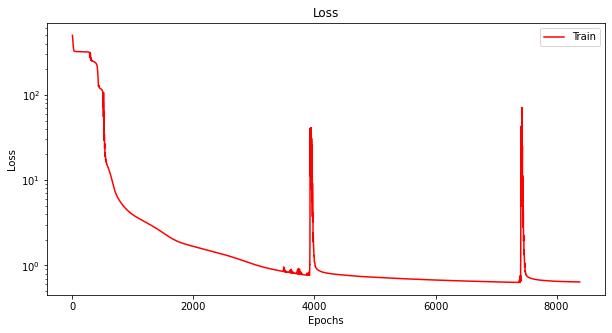

simulation time:31m 15s


In [27]:
os.makedirs(WORK_DIR + '/models', exist_ok=True)
os.makedirs(WORK_DIR + '/history', exist_ok=True)

s = DX1N * DX2N * LIM1[1] * LIM2[1]

# Перемещение на GPU
flowDomainMask = flowDomainMask.to(DEVICE)
lowerWallMask = lowerWallMask.to(DEVICE)
DX1N = DX1N.to(DEVICE)
DX2N = DX2N.to(DEVICE)
s = s.to(DEVICE)

run_record = {}

for hyp in HYPS:
    print('hyperparams: \n', dict2str(hyp)) 

    model_path = (f'{WORK_DIR}/models/{MODEL_NAME}_{dict2str(hyp)}.pth')

    callbacks = [SaveBest(f'Train loss', model_path, 'min'),
                 EarlyStop(f'Train loss', EARLY_STOP_PATIENCE, 'min')]

    model = MLP(2, hyp['hidden_neurons'], hyp['hidden_layers'])
#     model.load_state_dict(torch.load(f'{WORK_DIR}/models/{MODEL_NAME}_best1.pth'))
    model = model.to(DEVICE)
    
    if hyp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=hyp["learning_rate"], weight_decay=DECAY)
    elif hyp["optimizer"] == "LBFGS":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=50000,
                            max_eval=50000, tolerance_change=np.finfo(float).eps)
    
    criterion = power_loss
    
    #Log model, criterion, and optimizer
#     run["config/model"] = type(model).__name__
#     run["config/criterion"] = type(criterion).__name__
#     run["config/optimizer"] = type(optimizer).__name__

    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                                  patience=hyp["scheduler_patience"],
                                                                  min_lr=1e-6, factor=hyp["scheduler_factor"])
    elif hyp["scheduler"] == "cycle":
        lr_scheduler = scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hyp["learning_rate"] * 20,
                                                                       steps_per_epoch=1, epochs=EPOCHS,
                                                                       pct_start=0.125,
                                                                       div_factor=hyp["scheduler_factor"] ** -1,
                                                                       final_div_factor=(hyp["scheduler_factor"] ** -1) * 50)
    else:
        lr_scheduler = None
        

    history = train(model, [flowDomainMask, lowerWallMask], optimizer, power_loss,
                    epochs=EPOCHS, print_every=1,
                    callbacks=callbacks, lr_scheduler=lr_scheduler)

    run_record[model_path] = {'hyperparams': hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}

    print(f"Best Train loss %4.4f" % (callbacks[1].best_monitor))

    model = None
    optimizer = None

    torch.cuda.empty_cache()

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric > train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}/history/{MODEL_NAME}_history.json', 'w') as fp:
    json.dump(run_record, fp)

best_hyp = str(best_hyperparams).replace("}", "")
best_hyp = best_hyp.replace("{", "")
best_hyp = best_hyp.replace("'", "")

print(f"Best Train loss: %4.4f, best hyperparams: %s" % (best_val_metric, best_hyp))

model = MLP(2, best_hyperparams['hidden_neurons'], best_hyperparams['hidden_layers'])
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}/models/{MODEL_NAME}_best.pth')

model = model.to(DEVICE)

plot_train_history(best_run['history'])

simulation_time = time.time() - start_time
print('simulation time:{:.0f}m {:.0f}s'.format(
      simulation_time // 60, simulation_time % 60))

## Results

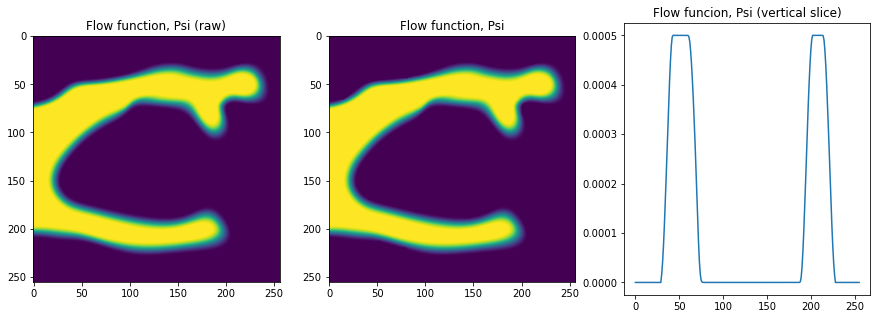

In [28]:
#Output of the network: psi function of the flow

x1 = X1N_V.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)
x2 = X2N_V.flatten().reshape(-1, 1).to(DEVICE).requires_grad_(True)

x = torch.cat((x1, x2), axis=1)

psi = model.forward(x)

psi_masked = (psi * flowDomainMask.to(DEVICE) + (lowerWallMask.to(DEVICE)*Q))
v1,v2 = velocityDistr(psi_masked, x1, x2, LIM1, LIM2)
xi11, xi12, xi22, EtaEta = TksiDistr(v1, v2, x1, x2, LIM1, LIM2)

int1EtaEta = torch.trapz(EtaEta.reshape(SIZE, SIZE) + v1.reshape(SIZE, SIZE)*Fm[0]+v2.reshape(SIZE, SIZE)*Fm[1])
int2EtaEta = torch.trapz(int1EtaEta)
out = 0.5*MU*s*int2EtaEta #doublelIntegral(0.5*mu*EtaEta,lim1,lim2) #loss
    
#Visualization
nr=1
nc=3
fig = plt.figure(figsize=(FIGSIZE*nc, FIGSIZE*nr))
plt.subplot(nr,nc,1)
plt.imshow(psi.detach().to('cpu'))
plt.title('Flow function, Psi (raw)')

plt.subplot(nr,nc,2)
plt.imshow(psi_masked.detach().to('cpu'))
plt.title('Flow function, Psi')

plt.subplot(nr,nc,3)
plt.plot(psi_masked[:,sp].detach().to('cpu'))
plt.title('Flow funcion, Psi (vertical slice)')

plt.show()

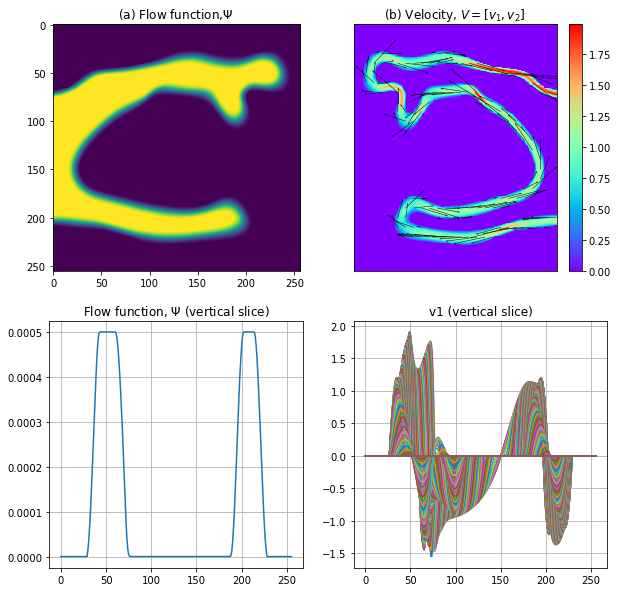

v1_max =  tensor(1.9044, device='cuda:0', grad_fn=<MaxBackward1>) v1_min =  tensor(-1.5475, device='cuda:0', grad_fn=<MinBackward1>)


In [29]:
#Visualization
nr=2
nc=2
fig = plt.figure(figsize=(FIGSIZE*nr, FIGSIZE*nc))
plt.subplot(nr,nc,1)
plt.imshow(psi_masked.detach().to('cpu'))
plt.title('(a) Flow function,$\Psi$')

plt.subplot(nr,nc,2)
vector_plot(np.meshgrid(-X1N,-X2N), [np.array(v1.detach().cpu().reshape(SIZE, SIZE)),
                                     np.array(v2.detach().cpu().reshape(SIZE, SIZE))],FIGSIZE, 
            '(b) Velocity, $V = [v_1, v_2]$', 10)
plt.xticks([])
plt.yticks([])

plt.subplot(nr,nc,3)
plt.plot(psi_masked[:,sp].detach().to('cpu'))
plt.grid(True)
plt.title('Flow function, $\Psi$ (vertical slice)')

plt.subplot(nr,nc,4)
plt.plot(v1.detach().cpu().numpy().reshape(SIZE, SIZE))
plt.grid(True)
plt.title('v1 (vertical slice)')

plt.show()
print('v1_max = ', v1.max(), 'v1_min = ', v1.min())

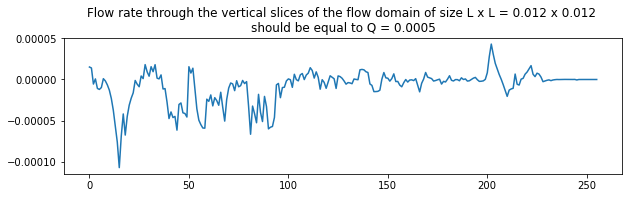

In [30]:
# Check the flow rate
Qch = torch.trapz(v1.detach().reshape(SIZE, SIZE).t()) * DX1N * L

fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(Qch.cpu())
plt.title(f'Flow rate through the vertical slices of the flow domain of size L x L = {L} x {L} \nshould be equal to Q = {Q}')
plt.show()

In [31]:
# print('Q = ', Qch.mean().cpu().item(), '; Loss = ', power_loss(psi).cpu().item())

In [32]:
print('Q = ', Qch.mean().cpu().item())

Q =  -8.563681149098556e-06


In [33]:
# print (EtaEta.cpu().min(), EtaEta.cpu().max(), EtaEtach.cpu().min(), EtaEtach.cpu().max()) 
# print(outch)


In [34]:

# print (EtaEta.cpu().min(), EtaEta.cpu().max(), EtaEtach.cpu()[:,sp].min(), EtaEtach.cpu()[:,sp].max()) 
# fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
# plt.plot(EtaEtach.cpu())
# plt.title('Eta*Eta')
# plt.show()

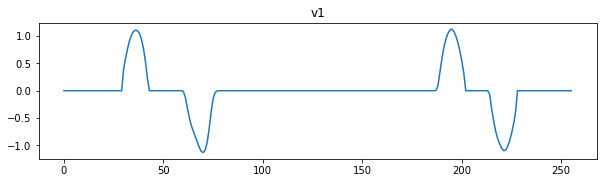

In [35]:
fig = plt.figure(figsize=(FIGSIZE*2, FIGSIZE/2))
plt.plot(v1.reshape(SIZE, SIZE).cpu().detach()[:,sp])
plt.title('v1')
plt.show()

In [36]:
#  #Check power
# Intch = power_loss(psi).cpu().item()*2
# Intch, Int_ex.item(), (Int_ex.item()-Intch)/Int_ex.item()

## Stop logging

In [37]:
# run.stop()

# Links

[1]. https://github.com/Mechanics-Mechatronics-and-Robotics/Mathematical_modelling/blob/main/Practice_1_by_IStebakov.ipynb

[2]. https://github.com/mateuszbuda/brain-segmentation-pytorch